# Woman、man、cemara、TV：如何做一个端到端的深度学习应用

前段时间 Trump 的[这个采访](https://www.youtube.com/watch?v=LhZyHIZpzoM)很火的时候，我正好在复习一些 neural network 的材料，于是想到可以用一些新的开源工具做一个识别 woman、man、cemara、TV 的完整应用试试。这个例子足够小，可以在很短时间完成，很适合用来说明如何做一个完整的深度学习应用。完成的应用部署在 https://trump-sim.netlify.app 。前端在 [Netlify](http://netlify.com)，后端部署在 [LeanCloud 国际版](https://leancloud.app)的云引擎上。

做这个应用分为三步：先用一些图片完成模型的训练，然后把模型导出，做一个后端的 API 用来识别图片，再做一个前端用来上传图片和显示结果。

## 准备训练数据

Jupyter notebook 是个很流行的用来做数据分析和机器学习的交互式环境，它可以把 Markdown 文档和 Python 代码放在一个笔记本里，也可以以图表、图片等友好的方式显示代码的运行结果。这里也会用到 FastAI，它是一个基于 PyTorch，提供了很多网络和文件操作便捷接口的开源库。这篇文章就是在 Jupyter notebook 里写的，所以你可以直接 clone 这个 repo、安装依赖、启动 Jupyter notebook。

```shell
git clone https://github.com/hjiang/trump-sim-notebook
pip install -r requirements.txt
jupyter notebook
```

我们还会用到 [Bing image search API](https://azure.microsoft.com/en-us/services/cognitive-services/bing-image-search-api/) 来获取做训练的图片，你需要自己注册并申请一个免费的 API KEY。当然，因为搜索到的图片是在很多第三方网站上的，所以你得确定能无障碍地访问中国之外的网站。🤷‍♂️

把你的 Bing image search API key 放在项目目录下的 `.env` 里，以免放在代码里泄露出去：

```
BING_SEARCH_API_KEY=XXXXXXXX....
```

然后在 Python 里读进来

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()
key = os.getenv('BING_SEARCH_API_KEY')

写一个函数用来搜索图片：

In [7]:
from azure.cognitiveservices.search.imagesearch import ImageSearchClient
from msrest.authentication import CognitiveServicesCredentials
from fastcore.foundation import L

def search_images_bing(key, term, min_sz=128):
    client = ImageSearchClient('https://api.cognitive.microsoft.com', CognitiveServicesCredentials(key))
    return L(client.images.search(query=term, count=150, min_height=min_sz, min_width=min_sz).value)

实际验证一下, 搜一张 Artemis 的图片：

Using downloaded and verified file: images/artemis.jpg


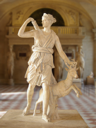

In [8]:
from torchvision.datasets.utils import download_url
from PIL import Image
import fastai2.vision.widgets

results = search_images_bing(key, 'Artemis')
urls = results.attrgot('content_url')
download_url(urls[0], 'images/', 'artemis.jpg')
image = Image.open('images/artemis.jpg')
image.to_thumb(128, 128)

确认图片下载没问题后，我们把关心的四类图片下载到 `/objects` 下面的四个目录里。

In [11]:
from fastai2.vision.utils import download_images
from pathlib import Path

object_types = 'woman','man','camera', 'TV'
path = Path('objects')

if not path.exists():
    path.mkdir()
    for o in object_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, o)
        download_images(dest, urls=results.attrgot('content_url'))


 Download of https://ae01.alicdn.com/kf/HTB17pv6QXXXXXcbaXXXq6xXFXXXm/Upgraded-Professional-Protax-POLO-SLR-D7200-13-Mega-Pixels-HD-Digital-Camera-with-Interchangeable-Lens.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p objects/camera
$ cd objects/camera
$ wget -c https://ae01.alicdn.com/kf/HTB17pv6QXXXXXcbaXXXq6xXFXXXm/Upgraded-Professional-Protax-POLO-SLR-D7200-13-Mega-Pixels-HD-Digital-Camera-with-Interchangeable-Lens.jpg
$ tar xf Upgraded-Professional-Protax-POLO-SLR-D7200-13-Mega-Pixels-HD-Digital-Camera-with-Interchangeable-Lens.jpg
 And re-run your code once the download is successful


 Download of https://ae01.alicdn.com/kf/HTB11DwlOVXXXXbdXXXXq6xXFXXXv/SHRXY-1-3-CCD-800TVL-Color-Home-Door-Hole-Eye-camera-Viewer-Security-mini-CCTV-Camera.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p objects/camera
$ cd objects/camera
$ wget -c https://ae01.alicdn.com/kf/HTB11DwlOVXXXXbdXXXXq6xXFXXXv/SHRXY-1-3-CCD-800TVL-Color-Home-Door-Hole-Eye-c

你可能会看到一些图片下载失败的信息，只要不是太多都可以忽略。因为网络上有的图片是损坏的，或者是 Python image library 不支持的格式，所以需要把无法通过验证的图片删除。

In [15]:
from fastai2.vision.utils import get_image_files
from fastai2.vision.utils import verify_images

fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink);

## 预处理

在开始训练前，需要告诉 FastAI 如何标注图片，并加载到它的数据结构中。下面的代码完成以下几件事：

- 使用父目录名（`parent_label`）来标注每个图片。
- 保留 20% 的图片作为验证集（validation set），其它的作为训练集（training set）。训练集就是用来训练神经网络的数据，验证集用于衡量训练好的模型在遇到新数据时的准确度的数据。所以这两个集合不能有重叠。
- 把图片缩小以提高效率

最后一行代码会显示验证集的前三个图片。

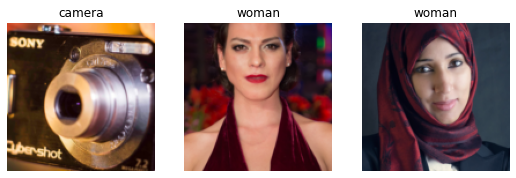

In [17]:
from fastai2.data.block import DataBlock, CategoryBlock
from fastai2.vision.data import ImageBlock
from fastai2.data.transforms import RandomSplitter, parent_label
from fastai2.vision.augment import Resize

objects = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

dls = objects.dataloaders(path)
dls.valid.show_batch(max_n=3, nrows=1)

在做图像识别的时候往往还会对图片做一些随机的缩放、裁剪等变换，以便产生足够多的数据来提高训练效果。可以从下面代码的结果看到对同一个图片做不同变换的结果。

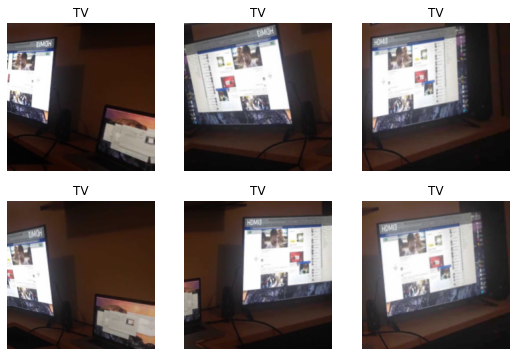

In [18]:
from fastai2.vision.augment import aug_transforms, RandomResizedCrop

objects = objects.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = objects.dataloaders(path)
dls.train.show_batch(max_n=6, nrows=2, unique=True)

## 训练数据

接下来终于可以开始训练了。对于图像识别这样的应用场景来说，往往不会从零开始训练一个新的模型，因为有大量的特征是几乎所有应用都需要识别的，比如物体的边缘、阴影、不同颜色形成的模式等。通常的做法是以一个预先训练好的模型为基础（比如这里的 `resnet18`），用自己的新数据对最后几层进行训练（通常称为 fine tune）。在一个多层的神经网络里，越靠前（靠近输入）的层负责识别的特征约具体，而越靠后的层识别的特征越抽象、越接近目的。下面的最后一行代码指训练 4 轮（epoch)。

如果你有 Nvidia 的显卡，在 Linux 下，并且安装了合适的驱动程序的话，下面的代码只需要几秒到十几秒，否则的话就要等待几分钟了。

In [24]:
from fastai2.vision.learner import cnn_learner
from torchvision.models.resnet import resnet18
from fastai2.metrics import error_rate
import fastai2.vision.all as fa_vision

learner = cnn_learner(dls, resnet18, metrics=error_rate)
learner.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.928001,0.602853,0.163793,01:16


epoch,train_loss,valid_loss,error_rate,time
0,0.550757,0.411835,0.120690,01:42
1,0.463925,0.363945,0.103448,01:46
2,0.372551,0.336122,0.094828,01:44
3,0.314597,0.321349,0.094828,01:44


最后输出的表格里是每一轮里训练集的 loss，验证集的 loss，以及错误率。错误率是我们关心的指标，而 loss 是控制训练的指标（训练过程就是让 loss 越来越接近于 0)。loss 越低错误率也越低，但他们之间没有线性关系。这里错误率有差不多 10%，也就是准确率是 90% 左右。

接下来我们要看看验证集里到底有哪些图片识别错了，下面的代码会打印出 confusion matrix。在这个矩阵里，对角线的数字是正确识别的图片数，而其它地方的是识别错误的图片数。

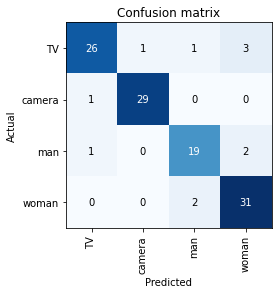

In [26]:
from fastai2.interpret import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

从输出的矩阵可以看到一共有 11 个错误，其中男女性别错误有 4 个，此外电视和其它几类的混淆也很多。🤔

下面我们把 loss 最高的图片显示出来看看具体有什么问题。

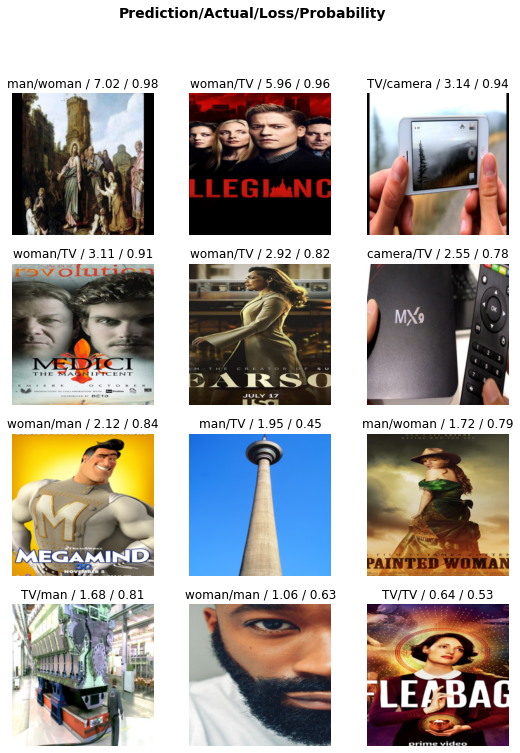

In [27]:
interp.plot_top_losses(12, nrows=4)

输出的结果反映出了从互联网上抓来的数据存在的典型问题：噪声太多。比如电视的搜索结果里有电视遥控器和电视盒子，电视屏幕上可能出现其它类别的物品，还有一些是完全无关的结果。

FastAI 提供了一个 cleaner 可以帮助我们对比较小的数据集做手动清洗。它可以把整个数据集中 loss 最高的图片列出来让用户可以手动修改标签或者删除。

In [68]:
from fastai2.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learner)
cleaner

注意 cleaner 只是做标记，你需要自己用 Python 代码来做实际处理。我通常就直接把有问题的图片删除。

In [42]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

清理完之后重复训练的过程。

In [70]:
objects = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

objects = objects.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = objects.dataloaders(path)
learner = cnn_learner(dls, resnet18, metrics=error_rate)
learner.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.663555,0.510397,0.201835,01:11


epoch,train_loss,valid_loss,error_rate,time
0,0.458212,0.226866,0.091743,01:32
1,0.358364,0.145286,0.036697,01:31
2,0.281517,0.146477,0.036697,01:32


如果你注意到 `error_rate` 在后面的 epoch 有上升的话，可以调整 `fine_tune` 的参数以达到最好的效果。因为如果训练轮数过多，模型会对训练集 over fit，在遇到新数据时错误率会变高。从上面的输出可以看到准确率提高到了 96% 以上。

达到满意的准确率后就可以把模型导出用到线上了。下面这行代码会把模型保存到 `export.pkl`

In [75]:
learner.export()

## 后端 API

后端 API 是这个项目最简单的一部分，只有一个 endpoint:

```python
trump = load_learner('model.pkl')

@app.route('/api/1.0/classify-image', methods=['POST'])
def classify():
    image = request.files['image']
    res = trump.predict(image.read())
    response = jsonify({'result': res[0]})
    response.status_code = 200
    return response
```

完整的代码在 [GitHub](https://github.com/hjiang/trump-sim-be) 上。按照[文档](https://leancloud.cn/docs/leanengine_webhosting_guide-python.html)部署到 LeanCloud 云引擎就行。

## 前端网站

前端也比较简单，只需要一个页面让用户上传照片，在浏览器里把照片缩小然后发送给后端 API 就可以。完整的 React 项目在 [GitHub](https://github.com/hjiang/trump-sim-fe)，主要的代码在 [App.js](https://github.com/hjiang/trump-sim-fe/blob/master/src/App.js)。限于篇幅就不详细说明了，只附上一张运行的截图：

![Screenshot](screenshot.png)

## 给读者的作业

你可能已经注意到上面的后端 API 服务是无状态的，没有存储任何数据，所以其实识别的过程可以在前端完成。如果你有兴趣的话，可以调研一下把 PyTorch 模型转化为 JavaScript 可用模型的框架，尝试在浏览器里直接识别照片。在真实的应用中，这样的方式由于不需要向服务端传输任何数据，可以完美地保护用户隐私，这也是 Apple 在推动的 on-device machine learning 的方向。